# Lab 01 : Semantic Segmentation - solution

The goal is to implement the CNN architecture that downsamples and upsamples the image domain by a factor 2 and 4, and classify the domain pixels.</br>
Downsample with `torch.nn.Conv2d`, https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html.</br>
Upsample with `torch.nn.ConvTranspose2d` : https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html.

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture12'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

In [3]:
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


### Generate the dataset 

In [4]:
# Libraries
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

# Import 5 object types
objects = torch.zeros(5,7,7)
nb_class_objects = 5
for k in range(nb_class_objects):
    objects[k,:,:] = 1-ToTensor()(Image.open('objects/obj'+str(k+1)+'.tif'))[0,:,:]
print(objects.size())

torch.Size([5, 7, 7])


torch.Size([2, 28, 28])


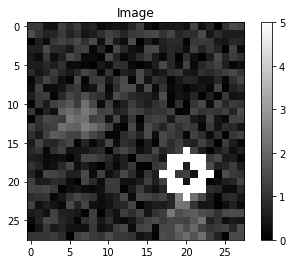

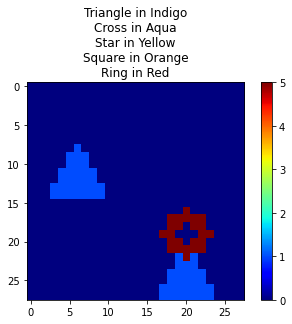

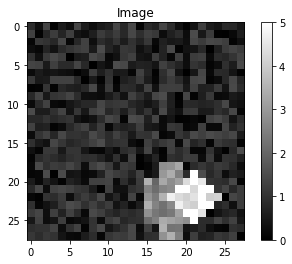

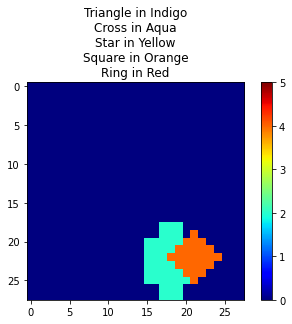

In [10]:
# Global constants
# im_size = image size  
# ob_size = object size
# batch_size = batch size
# nb_objects = number of objects in the image
# nb_object_classes = number of object classes (we have 5 classes)
# nb_pixel_classes = number of pixel classes (we have 5 classes and background)
# hidden_dim = hidden dimension

im_size = 28 
ob_size = 7
batch_size = 2
nb_objects = 3
nb_object_classes = 5
nb_pixel_classes = nb_object_classes + 1
hidden_dim = 64

# Function that generate a batch of training data
def generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_object_classes):
    batch_images = torch.zeros(batch_size,im_size,im_size)
    batch_labels = torch.zeros(batch_size,im_size,im_size)
    for b in range(batch_size):
        image = torch.zeros(im_size,im_size) # background pixel with label=0
        class_objects = torch.LongTensor(nb_objects).random_(1,nb_object_classes+1)
        offset = (ob_size-1)// 2
        coord_objects = torch.LongTensor(nb_objects,2).random_(offset,im_size-offset)
        # coord_objects[k,0] = x-coordinate,  coord_objects[k,1] = y-coordinate
        for k in range(nb_objects):
            image[coord_objects[k,1]-offset:coord_objects[k,1]-offset+ob_size,coord_objects[k,0]-offset:coord_objects[k,0]-offset+ob_size] = \
            torch.maximum( image[coord_objects[k,1]-offset:coord_objects[k,1]-offset+ob_size,coord_objects[k,0]-offset:coord_objects[k,0]-offset+ob_size], class_objects[k]*objects[class_objects[k]-1,:,:] ); 
        batch_images[b,:,:] = image + 1.5* torch.rand_like(image)
        batch_labels[b,:,:] = image
    return batch_images, batch_labels

# Plot a mini-batch of images
batch_images, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_object_classes)
print(batch_images.size())
for b in range(batch_size):
    plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.clim(0, 5)
    plt.colorbar()
    plt.title('Image')
    #plt.axis('off')
    plt.show() 
    plt.imshow(batch_labels[b,:,:], cmap='jet')
    plt.clim(0, 5)
    plt.colorbar()
    plt.title('Triangle in Indigo\nCross in Aqua\nStar in Yellow\nSquare in Orange\nRing in Red')
    plt.show() 


In [11]:
# Define the semantic_CNN architecture
batch_size = 2 # for debug

class semantic_CNN(nn.Module):
    
    def __init__(self):
        super(semantic_CNN, self).__init__()
        # downsampling convnet
        # COMPLETE HERE
        self.conv1 = nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1, stride=2) #  1x28x28 --> hidden_dim x14x14
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, stride=2) # hidden_dim x14x14 --> hidden_dim x7x7 
        # upsampling convnet
        # COMPLETE HERE
        self.trans_conv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, padding=1, stride=2) #  hidden_dim x7x7 --> hidden_dim x14x14
        self.trans_conv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, padding=1, stride=2) #  hidden_dim x14x14 --> hidden_dim x28x28
        # classification layer
        # COMPLETE HERE
        self.conv_class = nn.Conv2d(hidden_dim, nb_pixel_classes, kernel_size=3, padding=1, stride=1) #  hidden_dim x28x28 --> nb_pixel_classes x28x28
        
    def forward(self, x): 
        # downsampling convnet
        x = self.conv1(x) # [batch_size, hidden_dim, im_size/2, im_size/2] 
        x = torch.relu(x)
        x = self.conv2(x) # [batch_size, hidden_dim, im_size/4, im_size/4] 
        x = torch.relu(x) 
        # upsampling convnet
        x = self.trans_conv1(x) # [batch_size, hidden_dim, im_size/2, im_size/2] 
        x = torch.relu(x)
        x = self.trans_conv2(x) # [batch_size, hidden_dim, im_size, im_size] 
        x = torch.relu(x) 
        # classification layer
        scores_pixel_class = self.conv_class(x) # [batch_size, nb_pixel_classes, im_size, im_size] 
        return scores_pixel_class
    
# Instantiate the network
net = semantic_CNN()
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
batch_images, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_object_classes)
optimizer.zero_grad()
scores_pixel_class = net(batch_images.unsqueeze(dim=1)) # [batch_size, nb_pixel_classes, im_size, im_size]
labels_pixel_class = batch_labels.long() # [batch_size, im_size, im_size] 
# loss
loss = nn.CrossEntropyLoss()(scores_pixel_class, labels_pixel_class)
loss.backward()
optimizer.step()


semantic_CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (trans_conv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (trans_conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_class): Conv2d(64, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
There are 172230 (0.17 million) parameters in this neural network


In [12]:
# Training loop
net = semantic_CNN()
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.0025
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)

# Number of mini-batches per epoch
nb_batch = 100
batch_size = 10

start=time.time()
for epoch in range(10):

    running_loss = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        batch_images, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_object_classes)
        optimizer.zero_grad()
        scores_pixel_class = net(batch_images.unsqueeze(dim=1)) # [batch_size, nb_pixel_classes, im_size, im_size] 
        labels_pixel_class = batch_labels.long() # [batch_size, im_size, im_size] 
        # loss
        loss = nn.CrossEntropyLoss()(scores_pixel_class, labels_pixel_class)
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    

There are 172230 (0.17 million) parameters in this neural network
epoch= 0 	 time= 0.05651266972223918 min 	 lr= 0.0025 	 loss= 0.4078598047792912
epoch= 1 	 time= 0.11245292027791341 min 	 lr= 0.0025 	 loss= 0.17749494016170503
epoch= 2 	 time= 0.169694189230601 min 	 lr= 0.0025 	 loss= 0.11217485934495926
epoch= 3 	 time= 0.2261462370554606 min 	 lr= 0.0025 	 loss= 0.083924460709095
epoch= 4 	 time= 0.29170971711476645 min 	 lr= 0.0025 	 loss= 0.0647283897548914
epoch= 5 	 time= 0.3636481841405233 min 	 lr= 0.0025 	 loss= 0.05504414148628712
epoch= 6 	 time= 0.45121445258458454 min 	 lr= 0.0025 	 loss= 0.04378167038783431
epoch= 7 	 time= 0.5314499060312907 min 	 lr= 0.0025 	 loss= 0.04113407775759697
epoch= 8 	 time= 0.6098002354303996 min 	 lr= 0.0025 	 loss= 0.034952805703505875
epoch= 9 	 time= 0.6869370500246684 min 	 lr= 0.0025 	 loss= 0.0321730337664485


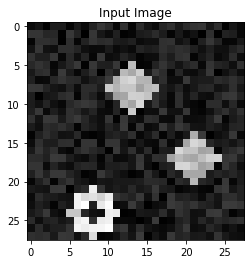

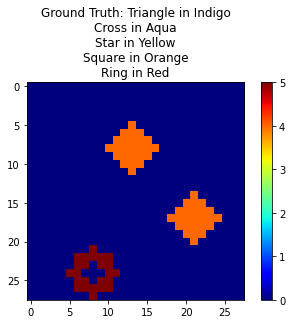

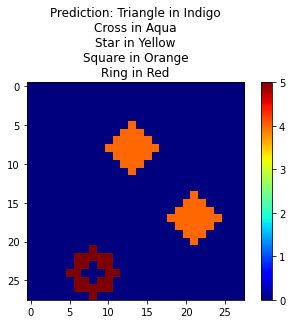

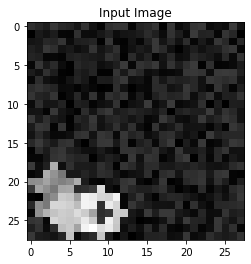

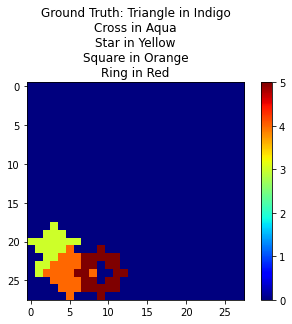

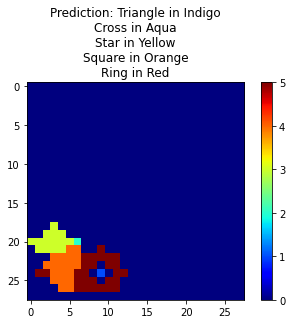

In [13]:
# Test time

# select a batch of 2 images
batch_size = 2 

# generate the batch of 2 images
batch_images, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_object_classes)

# forward pass
scores_pixel_class = net(batch_images.unsqueeze(dim=1)) # [batch_size, nb_pixel_classes, im_size, im_size]

# class prediction
pred_pixel_class = torch.argmax(scores_pixel_class, dim=1) # [batch_size, im_size, im_size] 

# Plot the ground truth solution and the predicted solution
for b in range(batch_size):
    
    # Plot ground truth and prediction
    plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.title('Input Image')
    plt.show() 
    
    plt.imshow(batch_labels[b,:,:], cmap='jet')
    plt.clim(0, 5)
    plt.colorbar()
    plt.title('Ground Truth: Triangle in Indigo\nCross in Aqua\nStar in Yellow\nSquare in Orange\nRing in Red')
    plt.show() 
    
    plt.imshow(pred_pixel_class[b,:,:], cmap='jet')
    plt.clim(0, 5)
    plt.colorbar()
    plt.title('Prediction: Triangle in Indigo\nCross in Aqua\nStar in Yellow\nSquare in Orange\nRing in Red')
    plt.show() 
